# Import

In [1]:
import os

from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import pickle
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import recall_score, roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.dummy import DummyClassifier

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve


In [14]:
def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def f1_(y_test, predictions):
    return f1_score(y_test, predictions)

def recall_(y_test, predictions):
    return recall_score(y_test, predictions)

def auc_(y_test, predictions):
    return roc_auc_score(y_test, predictions)

# Load Data

In [2]:
os.chdir('./data/')

In [3]:
feature_cols = [
    'SK_ID_CURR',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_EMPLOYED',
    'AMT_GOODS_PRICE',
    'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE',
    'BUREAU_MAX_DAYS_CREDIT',
    'BUREAU_MAX_DAYS_CREDIT_ENDDATE',
    'BUREAU_MAX_DAYS_ENDDATE_FACT',
    'PREV_SUM_MIN_AMT_PAYMENT',
    'PREV_MEAN_MIN_AMT_PAYMENT'
    ]

In [38]:
def load_data():
    data = {}
    for file in os.listdir():
        name = file.split('.')[0]
        data[name] = pd.read_csv(file, encoding='Latin-1')
    return data

def bureau(data, df, df_test):
    bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']
    bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]
    key = 'SK_ID_CURR'
    data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max)))
    bureau_cols = ['DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT']

    bureau_cols_max = ['BUREAU_MAX_' + c for c in bureau_cols]

    df = pd.merge(
      left=df,
      right=data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max))),
      left_on=key,
      right_index=True, 
      how='left'
  )
    df_test = pd.merge(
      left=df_test,
      right=data['bureau'][[key] + bureau_cols].groupby(key).max().rename(
          columns=dict(zip(bureau_cols, bureau_cols_max))),
      left_on=key,
      right_index=True, 
      how='left'
  )
    return df, df_test


def previous_app_and_installements(data, df, df_test):
    key_prev = 'SK_ID_PREV'
    payment_cols = ['AMT_PAYMENT']

    # Min payment for all previous loans
    data['previous_application'] = pd.merge(
      left=data['previous_application'],
      right=data['installments_payments'][[key_prev] + payment_cols].groupby(key_prev).min(),
      left_on=key_prev,
      right_index=True,
      how='left'
  )
    key = 'SK_ID_CURR'
    prev_agg_cols = ['PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT']

    # Sum and mean of minimum payments across all previous loans
    df_prev_agg = data['previous_application'][[key] + payment_cols].groupby(key).agg(['sum', 'mean']);
    df_prev_agg.columns = prev_agg_cols

    df = pd.merge(
      left=df,
      right=df_prev_agg,
      left_on=key,
      right_index=True,
      how='left'
  )

    df_test = pd.merge(
      left=df_test,
      right=df_prev_agg,
      left_on=key,
      right_index=True,
      how='left'
  )
    return df, df_test


def select_columns(df, df_test, feature_cols):
    return df[feature_cols], df_test[feature_cols], df['TARGET']


def main():
    data = load_data()
    df, df_test = data['application_train'], data['application_test']
    df, df_test = bureau(data, df, df_test)
    df, df_test = previous_app_and_installements(data, df, df_test)
    df, df_test, y = select_columns(df, df_test, feature_cols)

    df = df.fillna(value=df.mean())
    df_test = df_test.fillna(value=df.mean())

    df.SK_ID_CURR = df.SK_ID_CURR.astype(int)
    df_test.SK_ID_CURR = df_test.SK_ID_CURR.astype(int)
    return df, df_test, y

df, df_test, y = main()

In [39]:
X = df.drop(columns='SK_ID_CURR')

# Example: SK_ID_CURR #365597
X[df.SK_ID_CURR == 365597].transpose()

,229310
EXT_SOURCE_1,0.589340
EXT_SOURCE_2,0.507737
EXT_SOURCE_3,0.710674
DAYS_BIRTH,-10240.000000
AMT_CREDIT,152820.000000
AMT_ANNUITY,15241.500000
DAYS_EMPLOYED,-543.000000
AMT_GOODS_PRICE,135000.000000
DAYS_ID_PUBLISH,-355.000000
OWN_CAR_AGE,3.000000


In [40]:
df_test[df_test.SK_ID_CURR == 100001].transpose()

,0
SK_ID_CURR,100001.000000
EXT_SOURCE_1,0.752614
EXT_SOURCE_2,0.789654
EXT_SOURCE_3,0.159520
DAYS_BIRTH,-19241.000000
AMT_CREDIT,568800.000000
AMT_ANNUITY,20560.500000
DAYS_EMPLOYED,-2329.000000
AMT_GOODS_PRICE,450000.000000
DAYS_ID_PUBLISH,-812.000000


In [41]:
# creer un dataset avec toute la donnée
df['is_test'] = 0
df_test['is_test'] = 1
df_complete = pd.concat([df_test, df],axis=0)
df_complete.to_csv('./df_complete.csv', index=False)

In [42]:
# creer un dataset avec la donnée de test (sans le target)
df_test.to_csv('../data_test.csv', index=False )

In [43]:
df_test.set_index('SK_ID_CURR', inplace=True, drop=True)

# Model du notebook

In [264]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    #min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [21]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)
def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

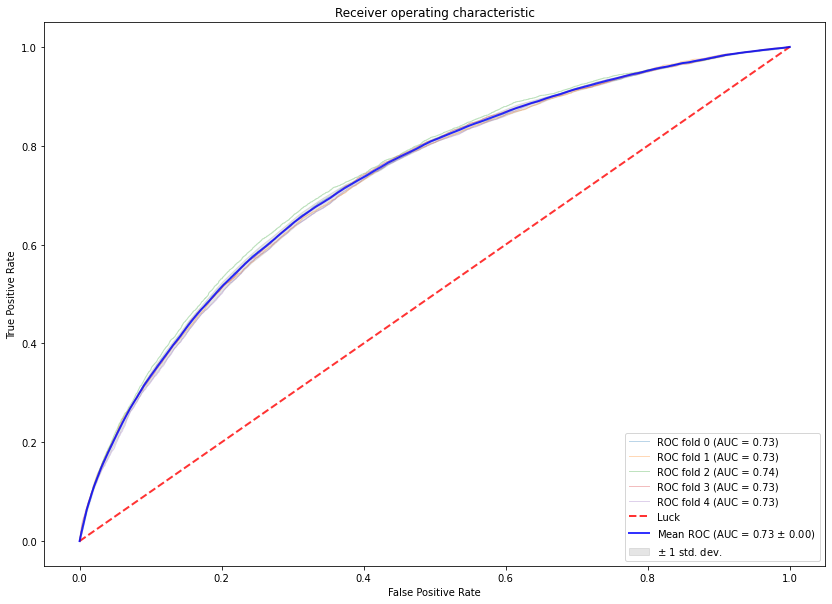

,AUC Train,AUC Test
0,0.736736,0.729911
1,0.737324,0.727502
2,0.734657,0.737889
3,0.737939,0.729900
4,0.737477,0.725004


In [20]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

# Entrainements 🦾

## Aucun prétraitement

Premiers modeles sans faire de prétraitement/finetuning \
Evaluation sur f1, recall et auc

### Baseline

In [42]:
dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X, y)

dummy_prediction = dummy_clf.predict(X_smote_moitie)
print('auc', auc_(y_smote_moitie, dummy_prediction))
print('f1', f1_(y_smote_moitie, dummy_prediction))
print('recall', recall_(y_smote_moitie, dummy_prediction))
#dummy_clf.score(X_smote_moitie, y_smote_moitie)

auc 0.49945522593973524
f1 0.12904988813171422
recall 0.08018791167585236


### EZEBARTI

In [23]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

models = {
    'logistic':LogisticRegression(class_weight='balanced', max_iter=1000),
    'randomforest':RandomForestClassifier(class_weight='balanced'),
    'knn' : KNeighborsClassifier()
}
#metrics = ['f1_', 'recall_', 'auc_']
res_model_simple={}

for model_name, model in models.items():
    print(f'{model_name} beggining .........')
    
    res_f1=[]
    res_recall=[]
    res_auc= []
    
    # je fais un split stratifié
    for train_ix, test_ix in skf.split(X, y):
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        predictions = fit_and_predict(model, X_train, y_train, X_test)
        res_f1.append(f1_(y_test, predictions))
        res_recall.append(recall_(y_test, predictions))
        res_auc.append(auc_(y_test, predictions))
    res_model_simple[model_name] = {'f1':np.mean(res_f1),
                                    'recall':np.mean(res_recall),
                                    'auc':np.mean(res_auc)
                     }
    print(f'{model_name} endding .........')

logistic beggining .........
logistic endding .........
randomforest beggining .........
randomforest endding .........
knn beggining .........


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.

knn endding .........


In [29]:
pd.DataFrame(res_model_simple)

,logistic,randomforest,knn
f1,0.185744,0.014667,0.042287
recall,0.557140,0.007452,0.023807
auc,0.583516,0.503353,0.507437


## With scale data

In [25]:
# Baseline ne change pas

In [30]:
X_scaled = X.copy()
col_to_scale = X_scaled.columns

for col in col_to_scale:
    scaler = StandardScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]])

In [31]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

res_scaled={}
for model_name, model in models.items():
    print(f'{model_name} beggining .........')
    
    res_f1=[]
    res_recall=[]
    res_auc= []
    
    # je fais un split stratifié
    for train_ix, test_ix in skf.split(X_scaled, y):
        X_train, X_test = X_scaled.iloc[train_ix], X_scaled.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        # je fit et predict sur le modele
        predictions = fit_and_predict(model, X_train, y_train, X_test)
        # je calcule mes métriques
        res_f1.append(f1_(y_test, predictions))
        res_recall.append(recall_(y_test, predictions))
        res_auc.append(auc_(y_test, predictions))
    # je conserve mes res
    res_scaled[model_name] = {
        'f1':np.mean(res_f1),
        'recall':np.mean(res_recall),
        'auc':np.mean(res_auc)
    }
    print(f'{model_name} endding .........')

logistic beggining .........
logistic endding .........
randomforest beggining .........
randomforest endding .........
knn beggining .........


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.

knn endding .........


In [32]:
pd.DataFrame(res_scaled)

,logistic,randomforest,knn
f1,0.248094,0.014041,0.080166
recall,0.654864,0.007130,0.047855
auc,0.668285,0.503199,0.517519


## Smote

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [9]:
# transform the dataset
oversample = SMOTE(k_neighbors=15, sampling_strategy=0.5)
X_smote_moitie, y_smote_moitie = oversample.fit_resample(X, y)

## Logit

In [33]:
neighboors = [5, 10, 20, 30, 50, 100]
smote_ratios = [0.2, 0.4, 0.5, 1.]



def evaluate_best_smote_ratio(model_name, n_iter):
    scores = {}
    for i in tqdm(range(n_iter)):
        res_f1=[]
        res_recall=[]
        res_auc= []
        # selectionne au hasard des variables de smote et créer la donnée
        neighboor = np.random.choice(neighboors)
        smote_ratio = np.random.choice(smote_ratios)
        oversample = SMOTE(k_neighbors=neighboor, sampling_strategy=smote_ratio)
        X_smote, y_smote = oversample.fit_resample(X, y)
        
        # k fold la donnée smote
        for train_ix, test_ix in skf.split(X_smote, y_smote):
            X_train, X_test = X_smote.iloc[train_ix], X_smote.iloc[test_ix]
            y_train, y_test = y_smote.iloc[train_ix], y_smote.iloc[test_ix]

            # je fit et predict sur le modele
            predictions = fit_and_predict(models[model_name],
                                          X_train,
                                          y_train,
                                          X_test)
            # je calcule mes métriques
            res_f1.append(f1_(y_test, predictions))
            res_recall.append(recall_(y_test, predictions))
            res_auc.append(auc_(y_test, predictions))

        scores[i]={
            'params':{'neighboor':neighboor,
                     'smote_ratio':smote_ratio},
            'f1':np.mean(res_f1),
            'recall':np.mean(res_recall),
            'auc':np.mean(res_auc)
        }
    return scores

In [34]:
model_to_test = ['logistic', 'randomforest']
res_smote = []
for model in model_to_test:
    res = evaluate_best_smote_ratio(model, 8)
    print(f'Pour le {model}, les valeurs sont les suivantes :')
    display(pd.DataFrame(res))
    res_smote.append(res)

  0%|                                                                  | 0/8 [07:15<?, ?it/s]


Le modele le plus scalable semble être le random forest 🌴🌳🌲🎄

# randomforest 🌴🌳🌲🎄

## created data

In [10]:
# diminue le nombre d'entrées pour gridsearch car j'ai pas un pc de la nasa 🚀
X_ = X.copy()
X_['target'] = y
print(len(X_))
X_ = X_.sample(int(len(X_)/3))
print(len(X_))
y_ = X_['target']
X_.drop(columns=['target'], inplace=True)


# transform the dataset with smote
oversample = SMOTE(k_neighbors=15, sampling_strategy=0.5)
X_smote_moitie_, y_smote_moitie_ = oversample.fit_resample(X_, y_)
X_smote_moitie, y_smote_moitie = oversample.fit_resample(X, y)

307511
102503


## Baseline

In [41]:
# baseline de la donnée smotée

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_smote_moitie, y_smote_moitie)
DummyClassifier(strategy='most_frequent')
dummy_prediction = dummy_clf.predict(X_smote_moitie)
print('auc', auc_(y_smote_moitie, dummy_prediction))
print('f1', f1_(y_smote_moitie, dummy_prediction))
print('recall', recall_(y_smote_moitie, dummy_prediction))
#dummy_clf.score(X_smote_moitie, y_smote_moitie)

auc 0.5009781170627481
f1 0.33443063962337616
recall 0.33422242346631953


## Model non finetuné

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# optimiser le nombre de faux positif/faux negatif -> pondérer


In [11]:
%%time
# model de "base" non finetuné
X_train, X_test, y_train, y_test = train_test_split(
    X_smote_moitie, y_smote_moitie, test_size=0.30, random_state=42)

rf = RandomForestClassifier(class_weight='balanced')

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

CPU times: user 1min 20s, sys: 527 ms, total: 1min 21s
Wall time: 1min 21s


In [15]:
print('auc', auc_(y_test, predictions))
print('f1', f1_(y_test, predictions))
print('recall', recall_(y_test, predictions))

auc 0.814617902727895
f1 0.7621820650754687
recall 0.6878372964438055


In [ ]:
rf.predict(df_test[df_test.index == 100001].values)

In [164]:
# save model
pickle.dump(rf, open('./random_orest_no_finetuning.pkl', 'wb'))

In [20]:
def get_features_importance(model,
                            features:list) -> pd.core.frame.DataFrame:
    '''get for each feature the importance for the model
    return it in DataFrame sorted deacreased'''
    importances = model.feature_importances_
    features_imp = pd.DataFrame(importances,
                                index=features,
                                columns=['feature_score']
                                )
    return features_imp.sort_values(by='feature_score',
                                    ascending=False)

def get_limit_values(features_imp, data, client_id):
    max_values = []
    min_values = []
    client_values = []
    for col in list(features_imp.index):
        max_values.append(data[col].max())
        min_values.append(data[col].min())
        client_values.append(data.loc[client_id, col])
    features_imp['max_value'] = max_values
    features_imp['min_value'] = min_values
    features_imp['client_value'] = client_values
    return features_imp

feature_imp = get_features_importance(rf, df_test.columns)
t = get_limit_values(feature_imp, df_test, 100001)

In [27]:
feature_imp.index

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1',
       'BUREAU_MAX_DAYS_CREDIT_ENDDATE', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
       'BUREAU_MAX_DAYS_ENDDATE_FACT', 'PREV_SUM_MIN_AMT_PAYMENT',
       'PREV_MEAN_MIN_AMT_PAYMENT', 'DAYS_EMPLOYED', 'BUREAU_MAX_DAYS_CREDIT',
       'AMT_ANNUITY', 'AMT_CREDIT', 'OWN_CAR_AGE', 'AMT_GOODS_PRICE'],
      dtype='object')

<AxesSubplot:xlabel='feature_score'>

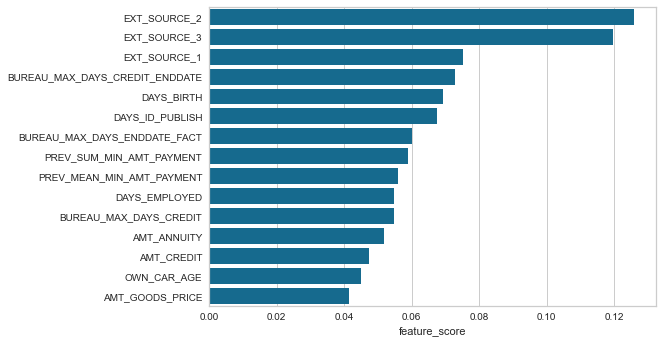

In [34]:
sns.barplot(y=feature_imp.index, x='feature_score', data=feature_imp, orient='h', color='b')

In [51]:
df_complete['EXT_SOURCE_1'].min()

0.0134579104986917

In [64]:
df_complete['a'] = df_complete['EXT_SOURCE_1'].apply(lambda x : np.float32(x))

In [75]:
df_complete

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,OWN_CAR_AGE,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT,is_test,a
0,100001,0.752614,0.789654,0.159520,-19241,568800.0,20560.5,-2329,450000.0,-812,12.061091,-49.000000,1778.000000,-544.000000,3951.000,3951.0000,1,0.752614
1,100005,0.564990,0.291656,0.432962,-18064,222768.0,17370.0,-4469,180000.0,-1623,12.061091,-62.000000,1324.000000,-123.000000,4813.200,4813.2000,1,0.564990
2,100013,0.502130,0.699787,0.610991,-20038,663264.0,69777.0,-4458,630000.0,-3503,5.000000,-1210.000000,-567.000000,-549.000000,6567.930,2189.3100,1,0.502130
3,100028,0.525734,0.509677,0.612704,-13976,1575000.0,49018.5,-1866,1575000.0,-4208,12.061091,-269.000000,30885.000000,-687.000000,12704.670,4234.8900,1,0.525734
4,100038,0.202145,0.425687,0.510853,-13040,625500.0,32067.0,-2191,625500.0,-4262,16.000000,-489.297817,4433.041953,-526.985948,11097.450,11097.4500,1,0.202145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.145570,0.681632,0.510853,-9327,254700.0,27558.0,-236,225000.0,-1982,12.061091,-489.297817,4433.041953,-526.985948,6605.910,6605.9100,0,0.145570
307507,456252,0.502130,0.115992,0.510853,-20775,269550.0,12001.5,365243,225000.0,-4090,12.061091,-489.297817,4433.041953,-526.985948,10046.880,10046.8800,0,0.502130
307508,456253,0.744026,0.535722,0.218859,-14966,677664.0,29979.0,-7921,585000.0,-5150,12.061091,-713.000000,1113.000000,-794.000000,5594.985,2797.4925,0,0.744026
307509,456254,0.502130,0.514163,0.661024,-11961,370107.0,20205.0,-4786,319500.0,-931,12.061091,-1104.000000,-859.000000,-859.000000,21362.265,10681.1325,0,0.502130


In [80]:
a = pd.melt(df_complete)

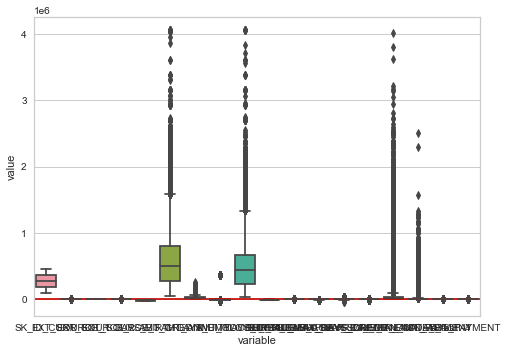

In [84]:
sns.boxplot(x='variable', y='value',data=a)


In [151]:
df_=df.copy()
df_['TARGET']=y

In [116]:
df_[df_.TARGET==0]['EXT_SOURCE_2']

1         0.622246
2         0.555912
3         0.650442
4         0.322738
5         0.354225
            ...   
307505    0.346391
307506    0.681632
307507    0.115992
307508    0.535722
307510    0.708569
Name: EXT_SOURCE_2, Length: 282686, dtype: float64

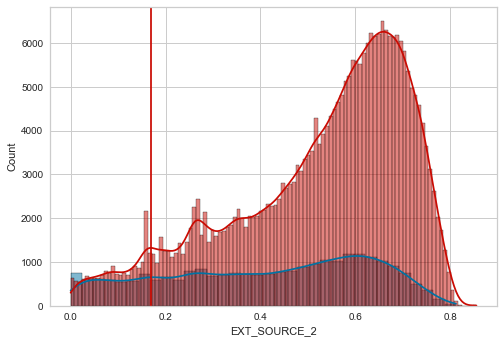

In [101]:
sns.histplot(df_[df_.TARGET==1]['EXT_SOURCE_2'], kde=True, color='b')
sns.histplot(df_[df_.TARGET==0]['EXT_SOURCE_2'], kde=True, color='r')
plt.axvline(0.17, color='r')

In [150]:
df_[['EXT_SOURCE_2', 'TARGET']]

,EXT_SOURCE_2,TARGET
0,0.262949,NaN
1,0.622246,NaN
2,0.555912,NaN
3,0.650442,NaN
4,0.322738,NaN
...,...,...
307506,0.681632,NaN
307507,0.115992,NaN
307508,0.535722,NaN
307509,0.514163,NaN


Text(0.5, 1.0, 'EXT_SOURCE_2 repartition according default client or not')

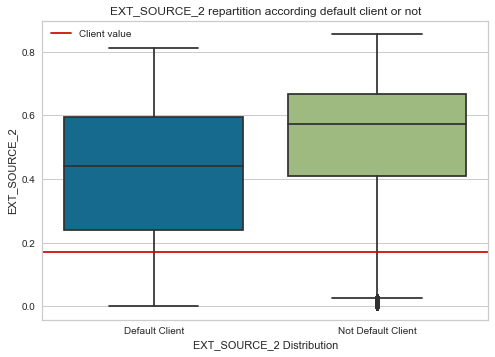

In [158]:
#a = pd.melt(df_[['EXT_SOURCE_2', 'TARGET']])
#df_['TARGET'] = df_['TARGET'].map({1:'Default Client', 0:'Not Default Client'})
ax = sns.boxplot(data=df_, y='EXT_SOURCE_2', x='TARGET',orient="v")
ax.set_xlabel('r')
ax.set_xlabel(f'EXT_SOURCE_2 Distribution')
ax.axhline(0.17, color='r', label='Client value')
plt.legend()
ax.set_title(f'EXT_SOURCE_2 repartition according default client or not')


## Shap

In [159]:
explainer = shap.TreeExplainer(rf)

In [62]:
rf.predict_proba(choosen_instance)

array([[0.97, 0.03]])

In [ ]:
%%time
shap_values_ = explainer.shap_values(df__)
#shap.summary_plot(shap_values, X_train, plot_type="bar")

In [160]:
# Calculate Shap values
choosen_instance = df_test.loc[[366845]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

In [165]:
df__.drop(columns=['SK_ID_CURR'], inplace=True)

In [162]:
df__ = df.drop(columns=['is_test', 'TARGET'])

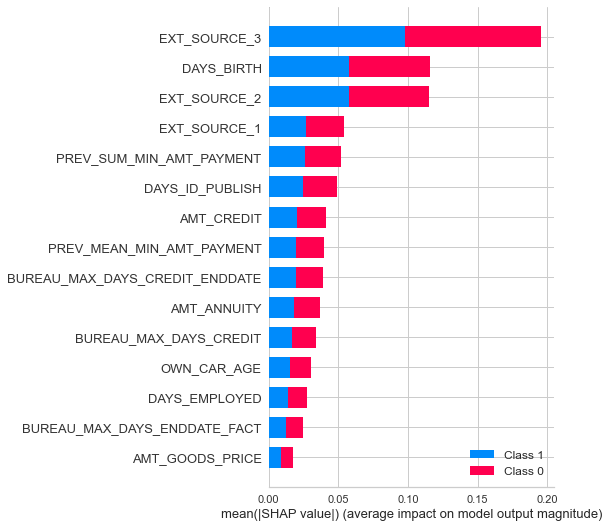

In [69]:
shap.summary_plot(shap_values, df)

## learning curves

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


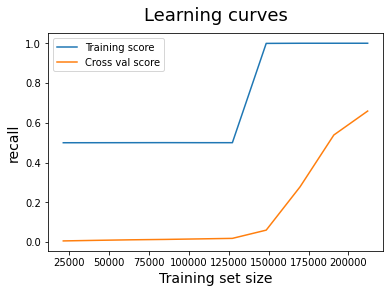

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.p

In [70]:
#train_sizes = [i for i in range(100, int(len(X)*0.1), 2000)]
train_sizes = np.linspace(0.1,1,10)
rf = RandomForestClassifier(class_weight='balanced')
learning_curves(rf, X_smote_moitie, y_smote_moitie, train_sizes, cv=2, scoring='recall')

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


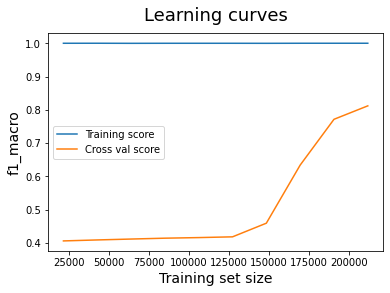

In [69]:
rf = RandomForestClassifier(class_weight='balanced')
learning_curves(rf, X_smote_moitie, y_smote_moitie, train_sizes, cv=2, scoring='f1_macro')

## Gridsearch

In [294]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 3000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 30, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 32, 54, 76, 98, 121, 143, 165, 187, 210, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 20],
 'min_samples_split': [2, 10, 30, 100],
 'n_estimators': [500, 777, 1055, 1333, 1611, 1888, 2166, 2444, 2722, 3000]}


In [295]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1, scoring='roc_auc', n_iter=100)
grid_search.fit(X_smote_moitie_, y_smote_moitie_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [160]:
def get_features_importance(model,
                            features:list) -> pd.core.frame.DataFrame:
    '''get for each feature the importance for the model
    return it in DataFrame sorted deacreased'''
    importances = model.feature_importances_
    features_imp = pd.DataFrame(importances,
                                index=features,
                                columns=['feature_score']
                                )
    return features_imp.sort_values(by='feature_score',
                                    ascending=False)


def get_limit_values(features_imp:pd.core.frame.DataFrame,
                     data:pd.core.frame.DataFrame,
                     client_id:int
                     ) -> pd.core.frame.DataFrame:
    '''create a dataframe with for each feature : 
    - min values
    - max values
    - client values
    '''
    max_values = []
    min_values = []
    client_values = []
    for col in list(features_imp.index):
        max_values.append(data[col].max())
        min_values.append(data[col].min())
        client_values.append(data.loc[data.index==client_id, col].values[0])
    features_imp['max_value'] = max_values
    features_imp['min_value'] = min_values
    features_imp['client_value'] = client_values
    return features_imp


df_complete.set_index('SK_ID_CURR', inplace=True, drop=True)
df_complete.drop(columns=['is_test'], inplace=True)
f = get_features_importance(rf,df_complete.columns)




In [161]:
f

,feature_score
EXT_SOURCE_2,0.123430
EXT_SOURCE_3,0.120616
EXT_SOURCE_1,0.074957
BUREAU_MAX_DAYS_CREDIT_ENDDATE,0.073426
DAYS_BIRTH,0.069170
DAYS_ID_PUBLISH,0.068446
BUREAU_MAX_DAYS_ENDDATE_FACT,0.059277
PREV_SUM_MIN_AMT_PAYMENT,0.059081
DAYS_EMPLOYED,0.055280
PREV_MEAN_MIN_AMT_PAYMENT,0.055221


In [162]:
df_complete.loc[df_complete.index==100001, 'EXT_SOURCE_1']

SK_ID_CURR
100001    0.752614
Name: EXT_SOURCE_1, dtype: float64

In [196]:
a = get_limit_values(f, df_complete, 100001)
#a = a.to_json()
a.iloc[:4, :]

,feature_score,max_value,min_value,client_value
EXT_SOURCE_2,0.123430,0.855000,8.173617e-08,0.789654
EXT_SOURCE_3,0.120616,0.896010,5.272652e-04,0.159520
EXT_SOURCE_1,0.074957,0.962693,1.345791e-02,0.752614
BUREAU_MAX_DAYS_CREDIT_ENDDATE,0.073426,31199.000000,-4.187500e+04,1778.000000


In [170]:
df_complete.columns

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'BUREAU_MAX_DAYS_CREDIT',
       'BUREAU_MAX_DAYS_CREDIT_ENDDATE', 'BUREAU_MAX_DAYS_ENDDATE_FACT',
       'PREV_SUM_MIN_AMT_PAYMENT', 'PREV_MEAN_MIN_AMT_PAYMENT'],
      dtype='object')

In [171]:
model

NameError: name 'model' is not defined

In [66]:

def learning_curves(estimator, X, y, train_size, cv=5, scoring=None)->None:
    '''
    - estimator = model
    - X=data
    - y=target
    - train_size = range for testing (ex : [25,50,75,100,250,500,750,1000]
    -cv = cross validation
    '''
    train_sizes, train_scores, test_scores = learning_curve(estimator,
                                                            X,
                                                            y,
                                                            train_sizes=train_size,
                                                            cv=cv,
                                                            n_jobs=-1,
                                                            scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Cross val score')
    plt.ylabel(str(scoring) if scoring else 'default_metric', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()

In [198]:
a = [56, 88]
', '.join(a)

TypeError: sequence item 0: expected str instance, int found

In [176]:
pd.DataFrame.from_dict(y, orient='index').transpose()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,OWN_CAR_AGE,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
